# 08. Force Matching 

In [1]:
import hoomd, hoomd.htf as htf, hoomd.md
import numpy as np, os
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Build the graph
graph = htf.graph_builder(63)
nlist = graph.nlist[:, :, :3]
# get r
r = tf.norm(nlist, axis=2)
# compute 1 / r while safely treating r = 0.
# pairwise energy. Double count -> divide by 2
epsilon = tf.Variable(0.5, name='lj-epsilon', trainable=True)
sigma = tf.Variable(0.5, name='lj-sigma', trainable=True)
inv_r6 = graph.safe_div(sigma**2, r**2)
p_energy = epsilon / 2.0 * (- inv_r6)
# sum over pairwise energy
energy = tf.reduce_sum(p_energy, axis=1, name='energy')
computed_forces = graph.compute_forces(energy)
# get target forces without leading variables
# sigma2 = tf.Variable(1.0, trainable=False)
inv_r62 = graph.safe_div(1.0, r**2)
p_energy2 = 1.0 / 2.0 * (- inv_r62)
energy2 = tf.reduce_sum(p_energy2, axis=1, name='energy2')
target_forces = graph.compute_forces(energy2)
minimizer, loss = htf.force_matching(target_forces[:,:3], 
                                         computed_forces[:,:3])
graph.save_tensor(loss, 'cost')
graph.save(force_tensor=computed_forces,
           model_directory='CG_tutorial/force_matching',
           out_nodes=[epsilon, sigma])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






In [3]:
# Make a bootstrap model
# make some variables
v = tf.Variable(2.0, name='epsilon')
s = tf.Variable(2.0, name='sigma')

#initialize and save them
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.save(sess, 'CG_tutorial/force_matching/bootstrap/model')

In [4]:
# run the simulation
model_dir = 'CG_tutorial/force_matching'
bootstrap_dir = os.path.join(model_dir, 'bootstrap')
hoomd.context.initialize("--mode=cpu")
with hoomd.htf.tfcompute(model_dir, bootstrap=bootstrap_dir,
                         bootstrap_map={'lj-epsilon': 'lj-epsilon',
                                        'lj-sigma': 'lj-sigma'
                                        }) as tfcompute:
    N = 64
    NN = 63
    rcut = 7.5
    system = hoomd.init.create_lattice(
        unitcell=hoomd.lattice.sq(a=4.0),
        n=[4,4])
    nlist = hoomd.md.nlist.cell(check_period=1)
    lj = hoomd.md.pair.lj(r_cut=rcut, nlist=nlist)
    lj.pair_coeff.set('A', 'A', epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.005)
    hoomd.md.integrate.nve(group=hoomd.group.all(
            )).randomize_velocities(kT=2, seed=2)
    tfcompute.attach(nlist, r_cut=rcut, save_period=10)
    hoomd.run(1000)
    input_nlist = tfcompute.get_nlist_array()

HOOMD-blue v2.5.1 CUDA (10.0) SINGLE SSE SSE2 
Compiled: 03/16/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Started TF Session Manager.
notice(2): Group "all" created containing 16 particles
notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur


INFO:tensorflow:The following quantities will computed:
INFO:t

In [5]:
time = np.arange(0, 1001, 10)
cost = np.empty(len(time))
epsilon = np.empty(len(time))
sigma = np.empty(len(time))
for i, t in enumerate(time):
    variables = hoomd.htf.load_variables(model_dir, names = ['cost', 'lj-epsilon', 'lj-sigma'], checkpoint = int(t), feed_dict=dict({'nlist-input:0':input_nlist}))
    cost[i] = variables['cost']
    epsilon[i] = variables['lj-epsilon']
    sigma[i] = variables['lj-sigma']

INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-0
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-10
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-20
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-30
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-40
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-50
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-60
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-70
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-80
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-90
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-100
INFO:tensorflow:Restoring parameters from CG_tutorial/force_matching/model-110
INFO:tensorflow:Restoring parameters from CG_tutorial/force_mat

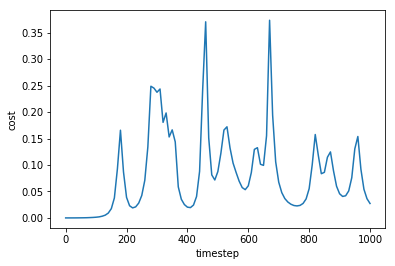

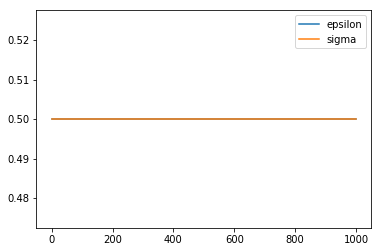

In [6]:
plt.figure()
plt.plot(time, cost) #, label = 'cost')
plt.xlabel('timestep')
plt.ylabel('cost')
plt.show()

plt.figure()
plt.plot(time, epsilon, label = 'epsilon')
plt.plot(time, sigma, label = 'sigma')
plt.legend()
plt.show()